# W-jet classification: QCD vs. W-jets

This is a simple example on Delphes-created FCC-simulations for W-jets and QCD-jets

In [1]:
from __future__ import print_function
import  keras, ROOT
import  logging, math, numpy as np
import  data_helpers

# Import some keras deps
from    keras.models       import Sequential
from    keras.layers       import Dense, Dropout, MaxPooling1D, Flatten, Conv1D
from    keras.regularizers import l2
import  keras.backend

Using TensorFlow backend.


Welcome to JupyROOT 6.12/06


In [2]:
# Settings
filename1 = './w_all.root'
filename2 = './qcd_all.root'
numTrainEvents = 19000
numValEvents   = 19000
learningRate   = 0.001
numEpochs      = 1

In [3]:
# Load data
data_W      = data_helpers.LoadDataConstituents(filename1, numTrainEvents)
val_data_W  = data_helpers.LoadDataConstituents(filename1, numValEvents, offset=numTrainEvents)
data_QCD      = data_helpers.LoadDataConstituents(filename2, numTrainEvents)
val_data_QCD  = data_helpers.LoadDataConstituents(filename2, numValEvents, offset=numTrainEvents)

# Create merged arrays & truth (shuffling is done by Keras for training data set)
data  = np.concatenate([data_W, data_QCD], axis=0)
truth = np.zeros(shape=len(data_W)+len(data_QCD))
for i in range(len(data_QCD), len(data_W)+len(data_QCD)):
  truth[i] = 1

val_data  = np.concatenate([val_data_W, val_data_QCD], axis=0)
val_truth = np.zeros(shape=len(val_data_W)+len(val_data_QCD))
for i in range(len(val_data_QCD), len(val_data_W)+len(val_data_QCD)):
  val_truth[i] = 1

In [4]:
# Define model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(len(data[0]), 4)))
model.add(Dropout(0.1))
model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

# Compile model, here loss function and optimizer are set
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 38, 64)            832       
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 36, 100)           12900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 100)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 36, 100)           10100     
__________

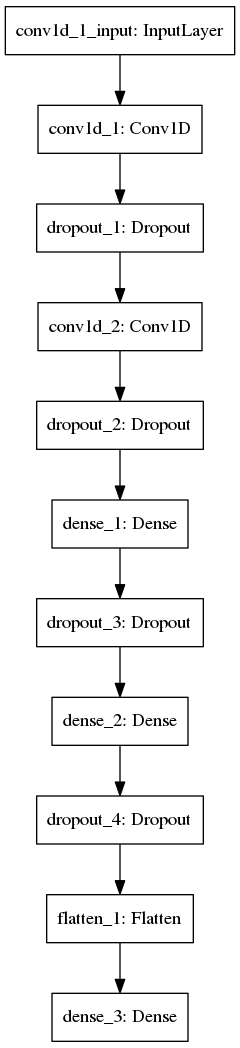

In [5]:
# Visualize model
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model.png')
Image('model.png')

In [6]:
np.set_printoptions(precision=3, suppress=True)
print('Sample 312 (truth={}):'.format(truth[312]))
print(data[312])


Sample 312 (truth=0.0):
[[    1.085     0.798    -1.135     1.   ]
 [    0.764     0.75     -1.138     1.   ]
 [  131.36      0.787    -1.137     0.   ]
 [   29.272     0.781    -1.15      1.   ]
 [  222.212     0.785    -1.144     2.   ]
 [   30.009     0.784    -1.138     0.   ]
 [   26.051     0.756    -1.141     0.   ]
 [   34.705     0.77     -1.126     0.   ]
 [   42.89      0.78     -1.149     0.   ]
 [  152.401     0.776    -1.15      1.   ]
 [ 1023.778     0.761    -1.138     0.   ]
 [   42.239     0.768    -1.15      1.   ]
 [  454.432     0.763    -1.139     0.   ]
 [  132.613     0.763    -1.139     0.   ]
 [   96.901     0.765    -1.135     0.   ]
 [  154.127     0.764    -1.136     0.   ]
 [  471.306     0.764    -1.139     0.   ]
 [   20.433     0.778    -1.136     0.   ]
 [  218.711     0.767    -1.136     0.   ]
 [   15.493     0.77     -1.135     0.   ]
 [ 1097.467     0.77     -1.136     1.   ]
 [   47.482     0.777    -1.142     0.   ]
 [ 1600.065     0.771    -1.14

In [7]:
### Actual training is done here ###

keras.backend.set_value(model.optimizer.lr, learningRate) # set learning rate
hist = model.fit(data, truth, epochs=numEpochs, batch_size=100,
            validation_data=(val_data, val_truth), verbose=1)

Train on 38000 samples, validate on 38000 samples
Epoch 1/1
38000/38000 [==============================] - 136s 4ms/step - loss: 1.9992 - acc: 0.7306 - val_loss: 1.1976 - val_acc: 0.8231


In [8]:
scores   = model.predict(val_data, batch_size=100, verbose=0)
scores_g = model.predict(val_data[0:numValEvents], batch_size=100, verbose=0)
scores_q = model.predict(val_data[numValEvents:numValEvents*2], batch_size=100, verbose=0)

######## Use your favorite plotter here
scores_q_hist = ROOT.TH1D("ScoresQ", "Score distribution", 100, 0, 1.0)
scores_q_hist.SetLineColor(ROOT.kBlack)
scores_g_hist = ROOT.TH1D("ScoresG", "Score distribution", 100, 0, 1.0)
scores_g_hist.SetLineColor(ROOT.kRed)
for sc in scores_g:
  scores_g_hist.Fill(sc[0])
for sc in scores_q:
  scores_q_hist.Fill(sc[0])

canvas = ROOT.TCanvas()
scores_q_hist.Draw()
scores_g_hist.Draw('same')
canvas.Draw()
canvas.Print('./Classification_Scores.eps')

from sklearn.metrics import roc_curve, auc
ROCy, ROCx, _ = roc_curve(val_truth, scores)
AUC = auc(ROCy, ROCx)
print('AUC={:f}'.format(AUC))

AUC=0.883379


Info in <TCanvas::Print>: eps file ./Classification_Scores.eps has been created


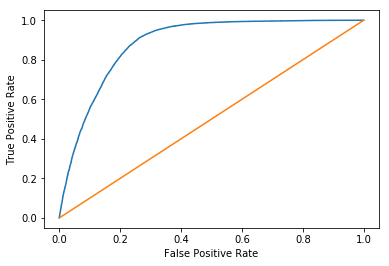

In [9]:
# Plot the ROC curve
import matplotlib.pyplot as plot
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')

plot.plot(ROCy, ROCx) # ROC curve
plot.plot(ROCy, ROCy) # Guessing curve
plot.show()
